In [12]:
from pdastro import pdastrostatsclass,pdastroclass,AnotB
import re
import numpy as np
import re,os,sys,shutil
### Get tweakreg_hack here:
### https://github.com/jpierel14/tweakreg_hack
### pip install .
### or 
### python setup.py install
### all credit for this awesome hack goes to Justin Pierel
import tweakreg_hack
from jwst import datamodels
from astropy.table import Table
import astropy.io.fits as fits
import matplotlib.pyplot as plt

###
### define cal_image, which then derives the name of the photometric catalog
### Make sure cal_image has the correct distortion coeffs applied!!

#cal_image = 'test/pid1069_testonly/jw01069001001_02101_00001_nrca1_cal.fits' # 0.7 pixels stdev F070W
cal_image = 'nrc24_calfiles/jw01073003001_02101_00001_nrca1_cal.fits' # 0.08 pixels stdev F150W
#cal_image = 'coron_offsets/NRCA3_FULL_WEDGE_RND/jw01070001001_04101_00001_nrca3_cal.fits' #  
#cal_image = '/ifs/jwst/wit/nircam/commissioning/01069/dist_applied/v1/jw01069002002_04101_00002_nrcblong_cal.fits'
#cal_image = '/ifs/jwst/wit/nircam/commissioning/01070/dist_applied/v1/jw01070001001_04101_00001_nrca2_cal.fits'
cal_phot_filename = re.sub('cal\.fits$','cal.phot.txt',cal_image)
if cal_phot_filename == cal_image:
    raise RuntimeError(f'Could not determine photometry filename for {cal_image}')


#d2d is calculated when gaia is matched to the objects, and is the distance 
# between the objects and their matched gaia positions. Give a rough upper limit on 
# what a good match should fall into
d2d_max = None
dmag_max = 0.1
Nbright=None
showplots=2

###################################
# A couple of convenience functions

# for a given catalog phot, calculate dx, dy, and make some rough cuts on dmag, d2d, and Nbright
def calc_dxdy(phot,d2d_max=None,dmag_max=None,Nbright=None, ixs=None):
    ixs = phot.getindices(ixs)
    if d2d_max is not None:
        ixs = phot.ix_inrange('d2d',None,3*d2d_max,indices=ixs)
    if dmag_max is not None:
        ixs = phot.ix_inrange('dmag',None,dmag_max,indices=ixs)
    if Nbright is not None:
        ixs_sort = phot.ix_sort_by_cols(['mag'],indices=ixs)
        ixs = ixs_sort[:Nbright]
        phot.write(columns=['mag'],indices=ixs)
        
    print(f'# of matched objects that pass initial cuts: {len(ixs)}')
    phot.t.loc[ixs,'ddec'] = 3600.0*(phot.t.loc[ixs,'cat_dec'] - phot.t.loc[ixs,'dec'])
    phot.t.loc[ixs,'dra'] = 3600.0*(phot.t.loc[ixs,'cat_ra'] - phot.t.loc[ixs,'ra'])*np.cos(np.deg2rad(phot.t.loc[ixs,'dec']))
    phot.t.loc[ixs,'dx'] = phot.t.loc[ixs,'cat_x'] - phot.t.loc[ixs,'x']
    phot.t.loc[ixs,'dy'] = phot.t.loc[ixs,'cat_y'] - phot.t.loc[ixs,'y']
    return(ixs)

# These are the info plots to check out dx, dy for good and bad detections
def infoplots(phot,ixs_good,ixs_bad,dy_plotlim=(-4,4),dx_plotlim=(-4,4)):
    sp=[]
    xfigsize=15.0
    yfigsize=10.0
    plt.figure(figsize=(xfigsize,yfigsize))
    sp.append(plt.subplot(231))
    sp.append(plt.subplot(232))
    sp.append(plt.subplot(233))
    sp.append(plt.subplot(234))
    sp.append(plt.subplot(235))

    phot.t.loc[ixs_bad].plot.scatter('y','dx',ax=sp[0],ylim=dx_plotlim,color='red')
    phot.t.loc[ixs_good].plot.scatter('y','dx',ax=sp[0],ylim=dx_plotlim,ylabel='dx in pixels')
    phot.t.loc[ixs_bad].plot.scatter('x','dy',ax=sp[1],ylim=dy_plotlim,color='red')
    phot.t.loc[ixs_good].plot.scatter('x','dy',ax=sp[1],ylim=dy_plotlim,ylabel='dy in pixels')

    phot.t.loc[ixs_bad].plot.scatter('x','y',ax=sp[2],color='red')
    phot.t.loc[ixs_good].plot.scatter('x','y',ax=sp[2])
    
    phot.t.loc[ixs_bad].plot.scatter('sharpness','mag',ax=sp[3],color='red')
    phot.t.loc[ixs_good].plot.scatter('sharpness','mag',ax=sp[3])

    phot.t.loc[ixs_bad].plot.scatter('sharpness','dmag',ax=sp[4],color='red')
    phot.t.loc[ixs_good].plot.scatter('sharpness','dmag',ax=sp[4])

    return(sp)


In [3]:
# simple aperture photometry, and matching to Gaia
# !!!! You only need to run this if the cal.phot.txt file does not exist yet!!!
from simple_jwst_phot import jwst_photclass
calphot=jwst_photclass()
calphot.verbose = 2

# This is the LMC catalog we are using. I need to add a routine that gets Gaia sources from full sky
gaia_catname_for_testing='./LMC_gaia_DR3.nrcposs'
# minimum S/N for sources in image
SNR_min = 10.0

if not os.path.isfile(cal_image):
    raise RuntimeError(f'file {cal_image} does not exist!')

# Run photometry.
calphot.run_phot(cal_image,gaia_catname_for_testing,SNR_min=SNR_min)
print('DONE!')

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443

### Doing photometry on nrc24_calfiles/jw01073003001_02101_00001_nrca1_cal.fits
NO photometry catalog filename
Filename: nrc24_calfiles/jw01073003001_02101_00001_nrca1_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     351   ()      
  1  SCI           1 ImageHDU       112   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32 

2022-05-30 22:33:48,672 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


Converting units from MJy/sr to DN/s
Finding stars --- Detector: NRCA1, Filter: F150W
FWHM for the filter F150W: 1.77 px


2022-05-30 22:33:49,469 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


Background and rms using MMMBackground and MADStdBackgroundRMS: 0.13985030353069305 0.11468812676465207

Number of sources found in the image: 25925
-------------------------------------

radii:[3.54]pixels radius_sky_in:7.08 radius_sky_out:10.620000000000001  radius_for_mag:3.54
Performing aperture photometry for radius r = 3.54 px


2022-05-30 22:34:12,776 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:632: RuntimeWarning: invalid value encountered in log10
  table_aper['mag'] = -2.5 * np.log10(table_aper[self.colname('aper_sum_bkgsub',rad)])



Time Elapsed: 20.337520194000717
6324 out of 25925 entries remain in photometry table
Getting ./LMC_gaia_DR3.nrcposs and matching it
80.42989590062733 -69.52537943567059 0.012625532391511846
Matching reference catalog ./LMC_gaia_DR3.nrcposs
image objects are in x_idl=[-31.87,31.78] and y_idl=[-31.98,31.63] range
Keeping 332 out of 22544 catalog objects
Keeping 332  after removing NaNs from ra/dec
DONE!


nrc24_calfiles/jw01073003001_02101_00001_nrca1_cal.phot.txt
outdir: nrc24_calfiles
NRCA1
filter:F150W
pupil: CLEAR
effective exptime: 85.894
Nx=2048 Ny=2048
# of matched objects that pass initial cuts: 5822
dx median: 1.8179839999999672
dy median: 4.287765999999998
      aper_sum_3.5px  annulus_median_3.5px  aper_bkg_3.5px  \
0          57.188874              0.337081       13.270589   
1          35.223304              0.193021        7.599092   
2          51.869776              0.138721        5.461346   
3          86.190122              0.129515        5.098915   
4          36.401006              0.145514        5.728780   
...              ...                   ...             ...   
6319       83.418605              0.224751        8.848246   
6320       33.111283              0.148323        5.839360   
6321      266.966566              1.568980       61.769478   
6322      266.411683              1.242580       48.919342   
6323       44.481101              0.145730        5.

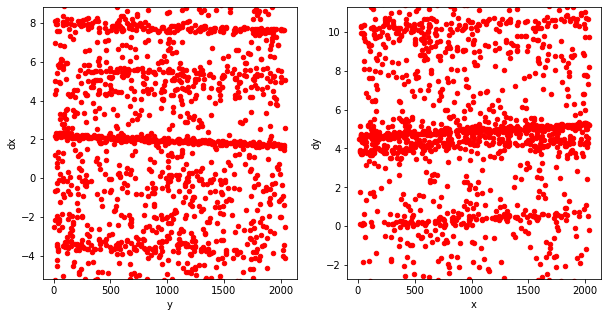

In [2]:
# Get a few essential info from the fits header
hdr = fits.getheader(cal_image)
hdrsci = fits.getheader(cal_image,extname='SCI')
#print(hdr)
outdir = os.path.dirname(cal_phot_filename)
print(f'{cal_phot_filename}\noutdir: {outdir}')
print(f'{hdr["DETECTOR"]}\nfilter:{hdr["FILTER"]}\npupil: {hdr["PUPIL"]}\neffective exptime: {hdr["EFFEXPTM"]}')
Nx=hdrsci['NAXIS1']
Ny=hdrsci['NAXIS2']
print(f'Nx={Nx} Ny={Ny}')

# Load the photometry file
phot_cal = pdastrostatsclass()
phot_cal.load(cal_phot_filename)
ixs_cal = calc_dxdy(phot_cal,d2d_max=d2d_max,dmag_max=dmag_max,Nbright=Nbright)

# set up 2 panel figure
sp=[]
xfigsize=10.0
yfigsize=5.0
plt.figure(figsize=(xfigsize,yfigsize))
sp.append(plt.subplot(121))
sp.append(plt.subplot(122))
 
# For both dx, dy:
# get the median and plot them with y-axis limits median+-delta_pix_ylim
delta_pix_ylim = 7

dx_median = phot_cal.t.loc[ixs_cal,'dx'].median()
dy_median = phot_cal.t.loc[ixs_cal,'dy'].median()

print(f'dx median: {dx_median}\ndy median: {dy_median}')

# these are the general limits for the y-axis for the plots
dy_plotlim = (dy_median-delta_pix_ylim,dy_median+delta_pix_ylim)
dx_plotlim = (dx_median-delta_pix_ylim,dx_median+delta_pix_ylim)

# plot the residuals
phot_cal.t.loc[ixs_cal].plot.scatter('y','dx',ax=sp[0],ylim=dx_plotlim,color='red')
phot_cal.t.loc[ixs_cal].plot.scatter('x','dy',ax=sp[1],ylim=dy_plotlim,color='red')
print(phot_cal.t)

In [3]:
### Define some functions

def initplot(nrows=1, ncols=1, figsize4subplot=5, **kwargs):
    sp=[]
    xfigsize=figsize4subplot*ncols
    yfigsize=figsize4subplot*nrows
    plt.figure(figsize=(xfigsize,yfigsize))
    counter=1
    for row in range(nrows):
        for col in range(ncols):
            sp.append(plt.subplot(nrows, ncols, counter,**kwargs))
            counter+=1

    for i in range(len(sp)):
        plt.setp(sp[i].get_xticklabels(),'fontsize',12)
        plt.setp(sp[i].get_yticklabels(),'fontsize',12)
        sp[i].set_xlabel(sp[i].get_xlabel(),fontsize=14)
        sp[i].set_ylabel(sp[i].get_ylabel(),fontsize=14)
        sp[i].set_title(sp[i].get_title(),fontsize=14)

    return(sp)

# plot the rotated dx or dy versus the original one
def plot_rotated(phot,ixs,d_col,col,
                 d_col_rot='__d_rot_tmp',
                 histolim=(-28,-12),
                 bins=None,
                 bin_weights_flag=False,
                 title=None):
    sp=initplot(1,2)

    phot.t.loc[ixs].plot.scatter(col,d_col,ax=sp[0],ylim=histolim,color='red',title=title)
    phot.t.loc[ixs].plot.scatter(col,d_col_rot,ax=sp[0],ylim=histolim,color='blue',ylabel=f'{d_col} in pixels')
    
    if bins is not None:
        if bin_weights_flag:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[1],bins=bins,weights=phot.t.loc[ixs,'__weights'],xlim=histolim,color='blue')
        else:
            phot.t.loc[ixs,d_col_rot].plot.hist(ax=sp[1],bins=bins,xlim=histolim,color='blue')

    return(sp)

# find the maximum value in yvals, its index, and the corresponding value in xvals
# also indicate if there are multiple entries with the same maximum value (multiple_max=True)
def find_info_for_maxval(xvals,yvals,use_firstindex_if_multiple=True):
    # get the max value of the histogram, and its associated bin
    #print(histo)
    maxval = np.max(yvals)
    ixs_max = np.where(yvals==maxval)
    multiple_max = None
    if (len(ixs_max[0])==0):
        raise RuntimeError('BUUUUGGGG!!!!')
    elif (len(ixs_max[0])>1):
        if not use_firstindex_if_multiple:
            raise RuntimeError(f'More than one indices {ixs_max} for maxval={maxval}')
        #print(f'\nWARNING!! More than one indices {ixs_max} for maxval={maxval}!')
        multiple_max=True
        ix_best=ixs_max[0][0]
    else:
        multiple_max=False
        ix_best=ixs_max[0][0]
    # return ()
    
    # get the (rough) fwhm of the peak
    ix_minus = ix_best-1 
    if ix_minus<0: ix_minus=0
    ix_plus = ix_best+1
    if ix_plus>len(yvals)-1: ix_plus=len(yvals)-1
    while (ix_minus>0):
        if yvals[ix_minus]<=0.5*yvals[ix_best]:
            break
        ix_minus-=1
    while (ix_plus<len(yvals)-1):
        if yvals[ix_plus]<=0.5*yvals[ix_best]:
            break
        ix_plus+=1
    fwhm = xvals[ix_plus]-xvals[ix_minus]
    
    return(xvals[ix_best],yvals[ix_best],ix_best,fwhm,multiple_max)

# straight line. Sloppy: use global slope and intercept
def f(val,slope,intercept):
    return(val*slope+intercept)

def rotate_d_and_find_binmax(phot,ixs,d_col,col,
                             Naxis_px, # Nx or Ny, depending on col
                             d_col_rot='__d_rot_tmp',
                             binsize=0.5,
                             bin_weights_flag=True,
                             slope_min=-10.0/2048.0, # 
                             slope_max=10.0/2048.0, # 
                             slope_stepsize=1.0/2048,
                             showplots=0):
    rot_results = pdastroclass()

    if bin_weights_flag:
        phot.t.loc[ixs,'__weights']=10**(-0.4*phot.t.loc[ixs,'mag'])
    else:
        phot.t.loc[ixs,'__weights']=None
        
    slopes = np.arange(slope_min,slope_max,slope_stepsize)
    for slope in slopes:
        #slope = delta4slope_pix/Nx
        intercept = -0.5*Naxis_px * slope

        phot.t.loc[ixs,d_col_rot] = phot.t.loc[ixs,d_col] - f(phot.t.loc[ixs,col],slope,intercept)

        # get the histogram
        d_rotated = phot.t.loc[ixs,d_col_rot]
        weights = phot.t.loc[ixs,'aper_sum_3.5px']
        bins = np.arange(np.min(d_rotated),np.max(d_rotated),binsize)
        if bin_weights_flag:
            histo = np.histogram(d_rotated,bins=bins,weights=phot.t.loc[ixs,'__weights'])
        else:
            histo = np.histogram(d_rotated,bins=bins)
        #sp = plt.subplot(111)
        #print(histo[1])
        #sp.plot(histo[1][1:], histo[0], 'ro')
        # get the max value of the histogram, and its associated bin center. Note that the bincenter is 
        # the value in the bins (left edge of the bin) + the half of the binsize
        (bincenter4maxval,maxval,index_maxval,fwhm,multiple_max) = find_info_for_maxval(histo[1]+0.5*binsize,histo[0])

        # Save the results
        rot_results.newrow({'slope':slope,
                            'intercept':intercept,
                            'maxval':maxval,
                            'index':index_maxval,
                            'd_bestguess':bincenter4maxval,
                            'fwhm':fwhm,
                            'multimax':multiple_max
                            })
        # plot it if wanted
        if showplots>1:
            plot_rotated(phot,ixs,
                         d_col,col,
                         d_col_rot=d_col_rot,
                         bins=bins,
                         bin_weights_flag=bin_weights_flag,
                         histolim = (bincenter4maxval-8,bincenter4maxval+8),
                         title=f'slope:{slope}')
        #sys.exit(0)

    # print the results        
    rot_results.write()
    
    # find the best rotation
    maxmaxval = np.max(rot_results.t['maxval'])
    ixs_maxmax = np.where(rot_results.t['maxval']==maxmaxval)
    if (len(ixs_maxmax[0])==0):
        raise RuntimeError('BUUUUGGGG!!!!')
    elif (len(ixs_maxmax[0])>1):
        #print(f'\nWARNING!! more than one bin with maxvalue={maxmaxval}!')
        multiple_max=True
        best_index=ixs_maxmax[0][0]
    else:
        multiple_max=False
        best_index=ixs_maxmax[0][0]
    print('####BEST:')
    rot_results.write(indices=[best_index])
    
    sp = initplot(3,1)
    rot_results.t.plot('slope','maxval',ax=sp[0],color='blue')
    rot_results.t.plot.scatter('slope','d_bestguess',ax=sp[1],color='blue')
    rot_results.t.plot.scatter('slope','fwhm',ax=sp[2],color='blue')
    sp[0].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
    sp[1].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
    sp[2].axvline(rot_results.t.loc[best_index,'slope'],  color='red',linestyle='-', linewidth=2.0)
    
    
    return(rot_results,best_index)

def sigmacut_d_rot(phot,ixs,
                   d_col,col,
                   slope,intercept,d_rot_bestguess,
                   rough_cut_px = 2.5, #This is the first rough cut:  get rid of everything d_rot_bestguess+-rough_cut_px
                   d_col_rot='__d_rot_tmp',
                   showplots=0,
                   binsize=0.5,
                   bin_weights_flag=True):

    ### recover the slope and intercept of the best binning
    phot.t.loc[ixs,d_col_rot] = phot.t.loc[ixs,d_col] - f(phot.t.loc[ixs,col],slope,intercept)
    
    # Now make the rough cut! only keep data for with dx_rotated within  d_rot_bestguess+-rough_cut_px
    ixs_roughcut = phot.ix_inrange(d_col_rot,d_rot_bestguess-rough_cut_px,d_rot_bestguess+rough_cut_px,indices=ixs)
    d_rotated = phot.t.loc[ixs,d_col_rot]
    
    if showplots:
        bins = np.arange(np.min(d_rotated),np.max(d_rotated),binsize)
        plot_rotated(phot,ixs_roughcut,
                     d_col,col,
                     d_col_rot=d_col_rot,
                     bins=bins,
                     bin_weights_flag=bin_weights_flag,
                     histolim = (d_rot_bestguess-3*rough_cut_px,d_rot_bestguess+3*rough_cut_px),
                     title=f'First rough cut: {d_rot_bestguess:.3f}+-{rough_cut_px:.3f} for slope={slope:.6f}')

    print('\n####################\n### d_rotated cut')
    #ixs_clean4average = phot_clear.ix_inrange(d_col,0,3,indices=ixs_clear_cut)
    phot.calcaverage_sigmacutloop(d_col_rot,verbose=3,indices=ixs_roughcut,percentile_cut_firstiteration=35)
    print(phot.statstring())
    ixs_cut = phot.statparams['ix_good']

    if showplots:
        #infoplots(phot,ixs_cut,ixs_roughcut,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)
        sp=initplot(1,2)

        phot.t.loc[ixs_roughcut].plot.scatter(col,d_col_rot,ax=sp[0],color='red')
        phot.t.loc[ixs_cut].plot.scatter(col,d_col_rot,ax=sp[0],ylabel='dx in pixels',title=f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left')
        
#        plot_rotated(phot,ixs_cut,
#                     d_col,col,
#                     d_col_rot=d_col_rot,
#                     histolim = (d_rot_bestguess-rough_cut_px,d_rot_bestguess+rough_cut_px),
#                     title=f'3-sigma cut: {len(ixs_cut)} out of {len(ixs_roughcut)} left')
    return(ixs_cut,ixs_roughcut)



        slope     intercept        maxval  index  d_bestguess  fwhm  multimax
-4.882812e-03  5.000000e+00  26699.912101   1884     3.036753   0.2     False
-4.557292e-03  4.666667e+00  25127.408556   1919     6.208646   0.2     False
-4.231771e-03  4.333333e+00  29776.404488   1889     2.880540   0.2     False
-3.906250e-03  4.000000e+00  27729.381836   1894     3.052433   0.3     False
-3.580729e-03  3.666667e+00  30391.537987   1889     2.224326   0.2     False
-3.255208e-03  3.333333e+00  33280.012435   1876     0.596220   0.2     False
-2.929688e-03  3.000000e+00  38403.247998   1865    -0.831887   0.2     False
-2.604167e-03  2.666667e+00  35821.526072   1892     1.540007   0.3     False
-2.278646e-03  2.333333e+00  41603.148733   1919     3.911900   0.2     False
-1.953125e-03  2.000000e+00  59535.183400   1908     2.483793   0.3     False
-1.627604e-03  1.666667e+00  55325.930374   1911     2.455687   0.4     False
-1.302083e-03  1.333333e+00  71812.516733   1913     2.327580   

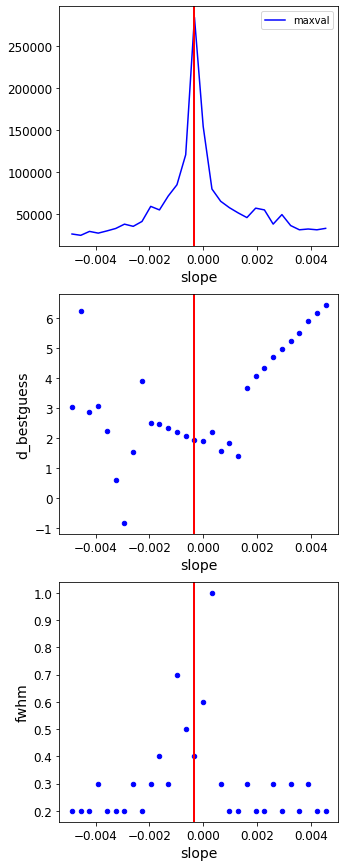

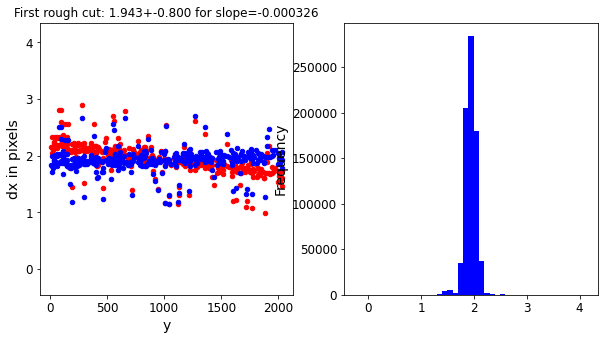

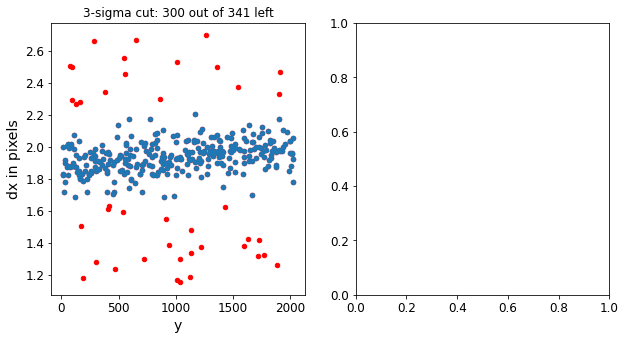

In [4]:
showplots=1
# showplots=0: no plots
# showplots=1: important plots
# showplots=2: all plots

bin_weights_flag=True
# If bin_weights_flag is set to True, then the dx/dy bins are weighted by
# the flux of the detection.

# Here we correct for rotation so that we can robustly remove outlier matches

# A straight line with a given slope is subtracted from dx versus y, which is 
# effectively a correction for a rotation.

# Then a histogram of the resulting dx_rotated is calculated with bin size = binsize_px in pixels.
# The maximum value of the histogram, it's associated dx_rot position, a rough upper limit estimate
# of the fwhm of the histogram peak are then saved for each slope and intercept in dx_rot_results (pdastro table).

# best_index is the index for this table for which the largest maxval of the histograms, presumably for 
# the best rotation (or slope)
binsize_px = 0.1

# slope loops from slope_min to slope_max with slope_stepsize
# slope_min=-10.0/2048.0 means that slopes with a range 
# of +-10 pixels of 2048 pixels are probed, i.e. dx does not change
# by more than 10 pixels over the full detector width
# A histogram of dx_rotated
slope_Nsteps = 30
slope_min=-10.0/2048.0
slope_max=-slope_min
slope_stepsize=(slope_max-slope_min)/slope_Nsteps

(dx_rot_results,dx_best_index) = rotate_d_and_find_binmax(phot_cal,ixs_cal,'dx','y',
                                                          Ny,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize,
                                                          showplots=showplots)
# Using the best dx_rotated, we first remove all entries with dx_rotated outside of dx_bestguess+-Nfwhm*fwhm
# Note that FWHM ~ 2.355 stdev, so Nfwhm*fwhm should be at least 3*stdev. This is the first ROUGH cut, with 
# which we just want to remove excessive amounts of outliers
Nfwhm = 2.0

(ixs_dx_cut,ixs_dx_roughcut) = sigmacut_d_rot(phot_cal,ixs_cal,'dx','y',
                                              dx_rot_results.t.loc[dx_best_index,'slope'],
                                              dx_rot_results.t.loc[dx_best_index,'intercept'],
                                              dx_rot_results.t.loc[dx_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dx_rot_results.t.loc[dx_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots
                                              )


        slope     intercept        maxval  index  d_bestguess  fwhm  multimax
-4.882812e-03  5.000000e+00  29932.304305    799     2.057438   0.3     False
-4.557292e-03  4.666667e+00  39286.414002    801     2.201965   0.2     False
-4.231771e-03  4.333333e+00  31479.222556    803     2.346492   0.3     False
-3.906250e-03  4.000000e+00  32048.664575    806     2.591020   0.3     False
-3.580729e-03  3.666667e+00  43973.149354    808     2.735547   0.2     False
-3.255208e-03  3.333333e+00  34286.124669    808     2.680074   0.2     False
-2.929688e-03  3.000000e+00  34308.056644    813     3.124601   0.4     False
-2.604167e-03  2.666667e+00  37385.592034    815     3.269128   0.2     False
-2.278646e-03  2.333333e+00  35879.783389    853     7.013656   0.2     False
-1.953125e-03  2.000000e+00  37613.724725    851     6.758183   0.2     False
-1.627604e-03  1.666667e+00  49494.768193    821     3.702710   0.3     False
-1.302083e-03  1.333333e+00  54967.286364    824     3.947237   

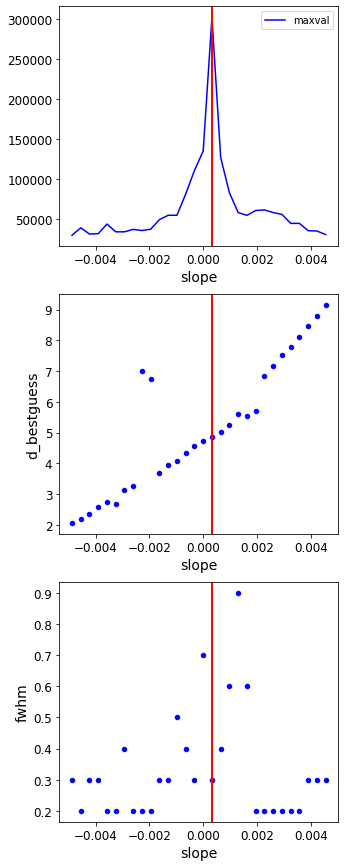

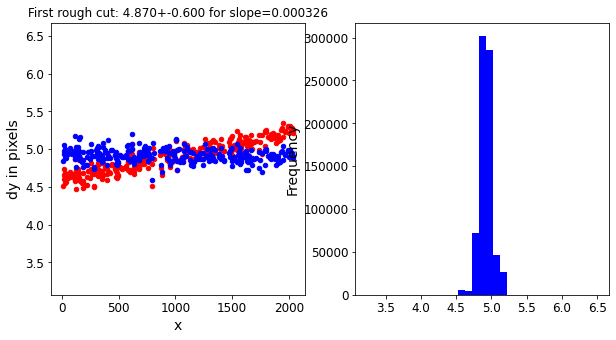

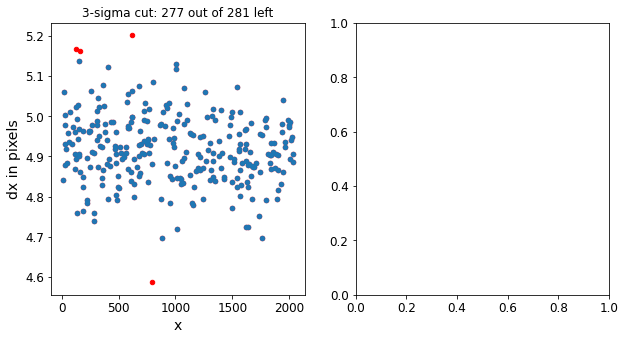

In [5]:
# Using the indices after the dx cut, we now also do a dy cut
slope = -dx_rot_results.t.loc[dx_best_index,'slope']
(dy_rot_results,dy_best_index) = rotate_d_and_find_binmax(phot_cal,ixs_dx_cut,'dy','x',
                                                          Nx,
                                                          binsize=binsize_px,
                                                          bin_weights_flag=bin_weights_flag,
                                                          slope_min=slope_min,
                                                          slope_max=slope_max,
                                                          slope_stepsize=slope_stepsize,
                                                          showplots=0)
(ixs_dy_cut,ixs_dy_roughcut) = sigmacut_d_rot(phot_cal,ixs_dx_cut,'dy','x',
                                              dy_rot_results.t.loc[dy_best_index,'slope'],
                                              dy_rot_results.t.loc[dy_best_index,'intercept'],
                                              dy_rot_results.t.loc[dy_best_index,'d_bestguess'],
                                              rough_cut_px = Nfwhm*dy_rot_results.t.loc[dy_best_index,'fwhm'],
                                              binsize=binsize_px,
                                              bin_weights_flag=bin_weights_flag,
                                              showplots=showplots
                                              )


good objects left: 277
median dmag of good object: 0.003802
median gaia_mag of good object: 18.951


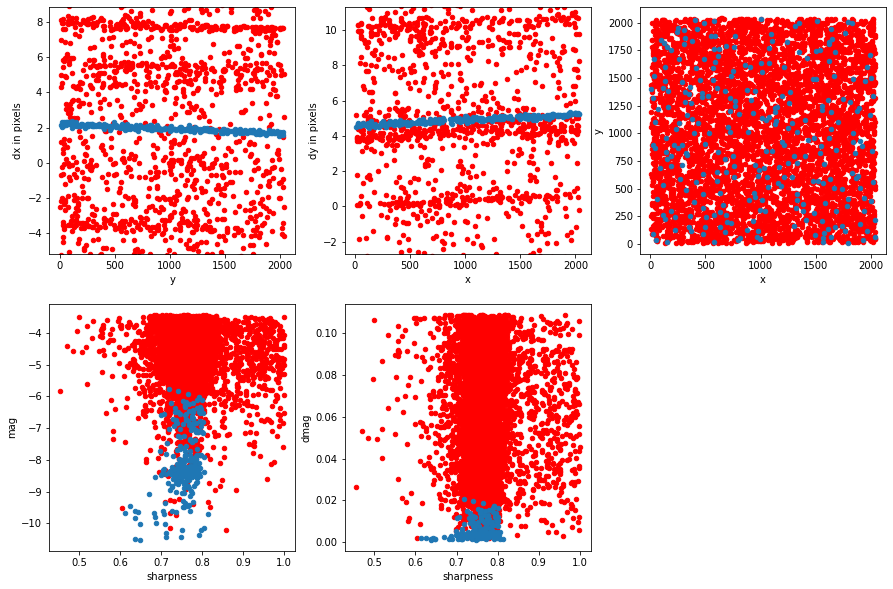

In [6]:
# show how good the selection of good data point is

# good data points
ixs_cal_good = ixs_dy_cut

# get the bad data points
ixs_cal_bad = AnotB(phot_cal.getindices(),ixs_cal_good)

infoplots(phot_cal,ixs_cal_good,ixs_cal_bad,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)

#phot_cal.write(indices=ixs_cal_good)

print(f'good objects left: {len(ixs_cal_good)}')

# some extra info:
dmag_median = phot_cal.t.loc[ixs_cal_good,'dmag'].median()
gaia_mag_median = phot_cal.t.loc[ixs_cal_good,'gaia_mag'].median()
print(f'median dmag of good object: {dmag_median}')
print(f'median gaia_mag of good object: {gaia_mag_median}')


In [11]:
### Pass the good matches after the dx and dy cuts to tweakreg and align it!

tweakreg = tweakreg_hack.TweakRegStep()
clobber = True
cal_image_dat = datamodels.open(cal_image)

tweakreg_image = f'{outdir}/'+re.sub('cal\.fits$','tweakregstep.fits',os.path.basename(cal_image))
print(f'{tweakreg_image}')
print(f'Setting output directory for tweakregstep.fits file to {outdir}')
tweakreg.output_dir = outdir
if not os.path.isdir(outdir):
    makepath(outdir)

if os.path.isfile(tweakreg_image):
    if clobber:
        os.remove(tweakreg_image)
    else:
        print('Not clobbering, so leaving.')
        sys.exit(1)
    
tweakreg.align_to_gaia = False
tweakreg.save_gaia_catalog = True
tweakreg.save_results = True
tweakreg.save_catalogs = True
tweakreg.snr_threshold = 50
tweakreg.separation = 9
tweakreg.searchrad = 0.5
tweakreg.minobj = 50
tweakreg.min_gaia = 30
#tweakreg.faintest_gaia_mag = 19
#tweakreg.brightest_gaia_mag = 15
# if you want to use x/yoffset, you need to set tweakreg.use2dhist=False
tweakreg.xoffset = 0
tweakreg.yoffset = 0
tweakreg.brightest = 1000
tweakreg.fitgeometry = 'rshift'

tweakreg.already_matched = True
# phot_cal.t.loc[ixs_cal_good] is the table with the good matches!
t =  Table.from_pandas(phot_cal.t.loc[ixs_cal_good])
tweakreg.refcat = t
tweakreg.ref_racol = 'cat_ra'
tweakreg.ref_deccol = 'cat_dec'

### Provide your own source catalog, to be used in place of the default daofinder stuff. If you actually have a list
### of images, it's okay to provide a source catalog for each. 
cal_image_dat.source_catalog = t
cal_data = [cal_image_dat]
tweakreg.source_xcol = 'x'
tweakreg.source_ycol = 'y'

tweakreg.run(cal_data)
print('DONE')

2022-05-31 10:06:46,552 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


nrc24_calfiles/jw01073003001_02101_00001_nrca1_tweakregstep.fits
Setting output directory for tweakregstep.fits file to nrc24_calfiles


2022-05-31 10:06:47,843 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01073003001_02101_00001_nrca1_cal.fits>],).
2022-05-31 10:06:47,847 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'nrc24_calfiles', 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 50, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 50, 'searchrad': 0.5, 'use2dhist': True, 'separation': 9, 'tolerance': 0.7, 'xoffset': 0, 'yoffset': 0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 30, 'save_gaia_catalog': True}
2022-05-31 10:06:47,865 - stpipe.TweakRegSt

DONE


In [12]:
# Do simple aperture photometry on the tweakreg fits file which should be aligned now!
from simple_jwst_phot import jwst_photclass
tweakregphot=jwst_photclass()
tweakregphot.verbose = 2

# This is the LMC catalog we are using. I need to add a routine that gets Gaia sources from full sky
gaia_catname_for_testing='./LMC_gaia_DR3.nrcposs'

# Minimum SNR of sources in image for the Gaia matching
SNR_min = 10.0
if not os.path.isfile(tweakreg_image):
    raise RuntimeError(f'BUG {tweakreg_image}')
# Run the photometry
tweakregphot.run_phot(tweakreg_image,gaia_catname_for_testing,SNR_min=SNR_min)
print('DONE!')


### Doing photometry on nrc24_calfiles/jw01073003001_02101_00001_nrca1_tweakregstep.fits
Filename: nrc24_calfiles/jw01073003001_02101_00001_nrca1_tweakregstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     353   ()      
  1  SCI           1 ImageHDU       112   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [117548762B]   


2022-05-25 17:11:35,615 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



None
Instrument: NIRCAM, aperture:NRCA1_FULL
Applying Pixel Area Map
Converting units from MJy/sr to DN/s
Finding stars --- Detector: NRCA1, Filter: F150W
FWHM for the filter F150W: 1.77 px


2022-05-25 17:11:36,434 - stpipe - WARNING - /Users/arest/anaconda/envs/jwst/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:411: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn('Input data contains invalid values (NaNs or '



Background and rms using MMMBackground and MADStdBackgroundRMS: 0.13985030353069305 0.11468812676465207

Number of sources found in the image: 25925
-------------------------------------

radii:[3.54]pixels radius_sky_in:7.08 radius_sky_out:10.620000000000001  radius_for_mag:3.54
Performing aperture photometry for radius r = 3.54 px


2022-05-25 17:11:59,949 - stpipe - WARNING - /Users/arest/nircam/jwst_distortions_tools/simple_jwst_phot.py:467: RuntimeWarning: invalid value encountered in log10
  table_aper['mag'] = -2.5 * np.log10(table_aper[self.colname('aper_sum_bkgsub',rad)])



Time Elapsed: 20.448614271999986
6324 out of 25925 entries remain in photometry table
Matching Gaia catalog ./LMC_gaia_DR3.nrcposs
image objects are in x_idl=[-31.80,31.85] and y_idl=[-31.83,31.78] range
Keeping 330 out of 22544 catalog objects
Keeping 330  after removing NaNs from ra/dec
Saving nrc24_calfiles/jw01073003001_02101_00001_nrca1_tweakregstep.phot.txt
DONE!


In [10]:
### show how good the alignment is: 
# load the photometric catalog from tweakreg image.
# make a rough cut of 0+-cut_delta_pix
# cut_delta_pix=2.5 should be big enough to not cut out any good measurements 
# After the rough cut, in the next cell a real 3-sigma clipping is done
tweakreg_phot_filename = re.sub('fits$','phot.txt',tweakreg_image)
if tweakreg_phot_filename==tweakreg_image:
    raise RuntimeError(f'BUG!! {tweakreg_image}')

# Load the file into pdastrostatsclass, which has robust 3-sigma cutting
phot_tweakreg = pdastrostatsclass()
phot_tweakreg.load(tweakreg_phot_filename)

# calculate dx and dy, and make some rough cuts
ixs_tweakreg = calc_dxdy(phot_tweakreg,d2d_max,dmag_max)

# Rough cut:
print('### Rough cut:')
cut_delta_pix = 2.5

dx_median = phot_tweakreg.t.loc[ixs_tweakreg,'dx'].median()
dy_median = phot_tweakreg.t.loc[ixs_tweakreg,'dy'].median()
print(f'dx median: {dx_median}')
print(f'dy median: {dy_median}')
dy_plotlim = (dy_median-3*cut_delta_pix,dy_median+3*cut_delta_pix)
dx_plotlim = (dx_median-3*cut_delta_pix,dx_median+3*cut_delta_pix)

dxlim = (dx_median-cut_delta_pix,dx_median+cut_delta_pix)
dylim = (dy_median-cut_delta_pix,dy_median+cut_delta_pix)
print(f'Cutting dx with {dxlim[0]:.3f} to {dxlim[1]:.3f} and dy with {dylim[0]:.3f} to {dylim[1]:.3f}')
ixs_tweakreg_roughcut = phot_tweakreg.ix_inrange('dx',dxlim[0],dxlim[1])
ixs_tweakreg_roughcut = phot_tweakreg.ix_inrange('dy',dylim[0],dylim[1],indices=ixs_tweakreg_roughcut)
ixs_tweakreg_bad = AnotB(phot_tweakreg.getindices(),ixs_tweakreg_roughcut)

infoplots(phot_tweakreg,ixs_tweakreg_roughcut,ixs_tweakreg_bad,dy_plotlim=dy_plotlim,dx_plotlim=dx_plotlim)

print(f'objects left: {len(ixs_tweakreg_roughcut)}')



NameError: name 'tweakreg_image' is not defined

In [9]:
import copy
# 3-sigma cut:
print('### 3-sigma cut:')
print('\n####################\n### dx')
#ixs_clean4average = phot_clear.ix_inrange('dx',0,3,indices=ixs_clear_cut)
phot_tweakreg.calcaverage_sigmacutloop('dx',verbose=3,indices=ixs_tweakreg_roughcut,percentile_cut_firstiteration=70)
dx_statparams = copy.deepcopy(phot_tweakreg.statparams)
# this are the good indices after the dx 3-sigma cut. They are getting fed into the dy 3-sigma cut!
ixs_dx_tweakreg_cut = dx_statparams['ix_good']
print(phot_tweakreg.statstring())

print('\n####################\n### dy')
phot_tweakreg.calcaverage_sigmacutloop('dy',verbose=3,indices=ixs_dx_tweakreg_cut,percentile_cut_firstiteration=70)
dy_statparams = copy.deepcopy(phot_tweakreg.statparams)
# this are the final good indices after both dx and dy 3-sigma cut
ixs_tweakreg_cut = dy_statparams['ix_good']
print(phot_tweakreg.statstring())


### 3-sigma cut:

####################
### dx


NameError: name 'phot_tweakreg' is not defined

NameError: name 'phot_tweakreg' is not defined

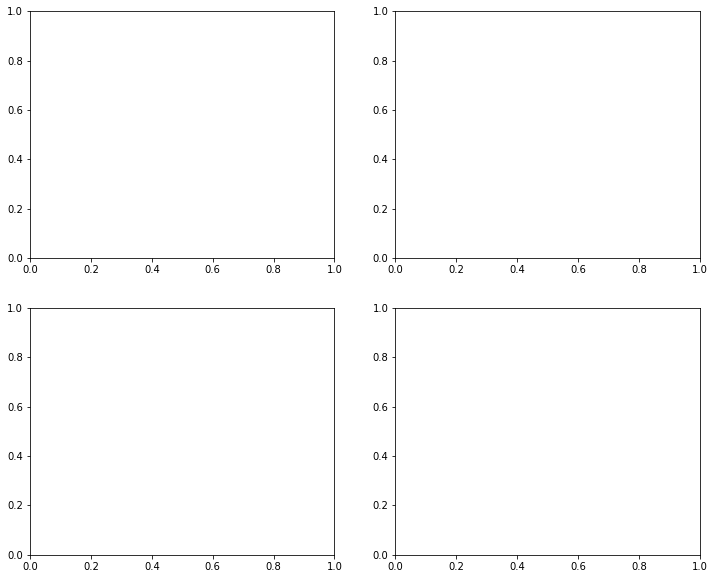

In [8]:
# plot the good measurments after the 3-sigma cut
saveplot=False
sp=[]
xfigsize=12.0
yfigsize=10.0
plt.figure(figsize=(xfigsize,yfigsize))
sp.append(plt.subplot(221))
sp.append(plt.subplot(222))
sp.append(plt.subplot(223))
sp.append(plt.subplot(224))
ixs_tweakreg_cut = phot_tweakreg.statparams['ix_good']

if re.search('5$|LONG$',hdr["detector"]) is not None:
    pixelscale=0.06
else:
    pixelscale=0.03

phot_tweakreg.t.loc[ixs_tweakreg_roughcut].plot.scatter('y','dx',ax=sp[0],color='red')
phot_tweakreg.t.loc[ixs_tweakreg_cut].plot.scatter('y','dx',ax=sp[0],ylabel='dx in pixels',title = f'{hdr["detector"]} {hdr["filter"]}, stdev = {dx_statparams["stdev"]:.3f} px = {dx_statparams["stdev"]*pixelscale*1000:.2f} mas')
sp[0].axhline(0.0,  color='black',linestyle='--', linewidth=1.3)
phot_tweakreg.t.loc[ixs_tweakreg_roughcut].plot.scatter('x','dx',ax=sp[1],color='red')
phot_tweakreg.t.loc[ixs_tweakreg_cut].plot.scatter('x','dx',ax=sp[1],ylabel='dx in pixels',title = f'{hdr["detector"]} {hdr["filter"]}, stdev = {dx_statparams["stdev"]:.3f} px = {dx_statparams["stdev"]*pixelscale*1000:.2f} mas')
sp[1].axhline(0.0,  color='black',linestyle='--', linewidth=1.3)

phot_tweakreg.t.loc[ixs_tweakreg_roughcut].plot.scatter('x','dy',ax=sp[2],color='red')
phot_tweakreg.t.loc[ixs_tweakreg_cut].plot.scatter('x','dy',ax=sp[2],ylabel='dy in pixels',title = f'{hdr["detector"]} {hdr["filter"]}, stdev = {dy_statparams["stdev"]:.3f} px = {dy_statparams["stdev"]*pixelscale*1000:.2f} mas')
sp[2].axhline(0.0,  color='black',linestyle='--', linewidth=1.3)
phot_tweakreg.t.loc[ixs_tweakreg_roughcut].plot.scatter('y','dy',ax=sp[3],color='red')
phot_tweakreg.t.loc[ixs_tweakreg_cut].plot.scatter('y','dy',ax=sp[3],ylabel='dy in pixels',title =  f'{hdr["detector"]} {hdr["filter"]}, stdev = {dy_statparams["stdev"]:.3f} px = {dy_statparams["stdev"]*pixelscale*1000:.2f} mas')
sp[3].axhline(0.0,  color='black',linestyle='--', linewidth=1.3)
for i in range(4):
    plt.setp(sp[i].get_xticklabels(),'fontsize',12)
    plt.setp(sp[i].get_yticklabels(),'fontsize',12)
    sp[i].set_xlabel(sp[i].get_xlabel(),fontsize=14)
    sp[i].set_ylabel(sp[i].get_ylabel(),fontsize=14)
    sp[i].set_title(sp[i].get_title(),fontsize=14)

plt.tight_layout()

if saveplot:
    tweakreg_plotfilename = re.sub('\.fits$','',tweakreg_image)
    tweakreg_plotfilename+='.png'
    print(f'Saving {tweakreg_plotfilename}')
    plt.savefig(f'{tweakreg_plotfilename}')
    #outdir='.'
    #plt.savefig(f'{outdir}/{hdr["detector"]}.{hdr["filter"]}.png')